In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *
LetsPlot.setup_html()

np.set_printoptions(suppress=True, threshold=np.inf, linewidth=np.inf)

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

In [3]:
from torchvision import transforms, datasets
from torchvision.datasets import MNIST

In [4]:
def load_mnist(train=True, data_path='./data_mnist'):
    transformers = []
    if train:
        transformers.extend([transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=(32, 32), padding=4)])
    transformers.append(transforms.ToTensor())
    return MNIST(data_path, train=train, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
    ]))

In [87]:
def plot_digit(digit, caption=None):
    digit = digit.reshape(28, 28)
    digit = (digit - np.min(digit))/(np.max(digit) - np.min(digit))
    p = ggplot() + geom_image(image_data=digit) + labs(x='', y='') \
        + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    if caption:
        p += ggtitle(caption)
    return p

In [5]:
def load_mnist_sample(data_path='./sample_mnist'):
    transformers = []
    transformers.append(transforms.ToTensor())
    return MNIST(data_path, train=train, download=True, transform=transforms.Compose(transformers))

In [6]:
def indices2captions(indices, caption_dict):
    captions = []
    for i in indices:
        caption = mnist_labels[i]
        captions.append(caption)
    return captions

In [7]:
def softmax(x):
    exp = np.exp(x)
    exp_sum = np.sum(exp, axis=1)[:, np.newaxis]
    return exp / exp_sum

In [8]:
class SublistDataset(Dataset):
    def __init__(self, dataset, start, end):
        self.__dataset = dataset
        self.__start = start
        self.__end = end

    def __getitem__(self, index):
        return self.__dataset[index - self.__start]

    def __len__(self):
        return self.__end - self.__start

In [9]:
train = load_mnist(train=True)
all_test = load_mnist(train=False)

In [10]:
test = SublistDataset(all_test, 1000, 10000)
dev = SublistDataset(all_test, 0, 1000)
dev_small = SublistDataset(all_test, 0, 200)

In [11]:
print(f'train: {len(train)} test: {len(test)} dev: {len(dev)} dev_small: {len(dev_small)}')

train: 60000 test: 9000 dev: 1000 dev_small: 200


In [12]:
sample = load_mnist_sample()
sample = SublistDataset(sample, 0, 200)

In [13]:
sample_images, sample_labels = [], []

In [14]:
for i in range(len(sample)):
    image, label = sample[i]
    sample_images.append(image)
    sample_labels.append(label)

In [15]:
mnist_labels = {0:'0', 1:'1',2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

In [16]:
captions = indices2captions(sample_labels, mnist_labels)

ind = np.random.randint(1, high=len(sample_images), size=25)
images = [sample_images[i] for i in ind]
labels = [captions[i] for i in ind]

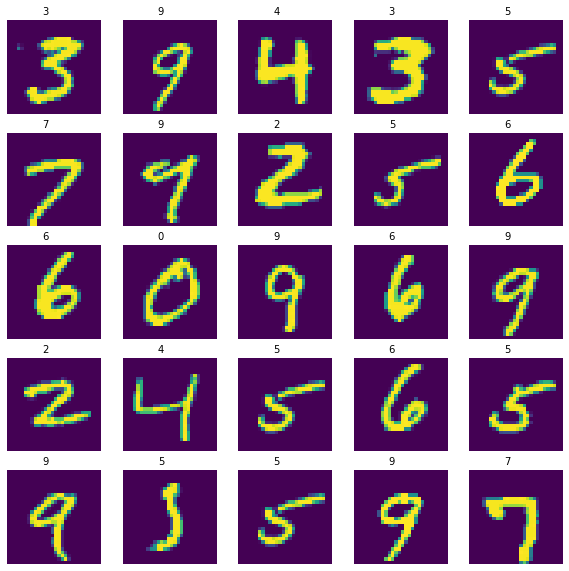

In [17]:
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))

for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[i*5 + j].reshape(28, 28))
        ax[i, j].text(10, -2, labels[i*5 + j])
        ax[i,j].axis('off')


In [18]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 3, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)
        self.fc = nn.Linear(147, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = x.view(-1, 147)
        x = self.fc(x)

        return x

In [54]:
def train_epoch(model, loader, opt):
    model.train(True)
    for i, data in enumerate(loader, 0):
        X, y = data[0], data[1]

#         if torch.cuda.is_available():
#             X = X.cuda()
#             y = y.cuda()

        opt.zero_grad()
        y_ = model(X)

        loss_value = loss(y_.float(), y)
        loss_value.backward()

        opt.step()

def get_accuracy_on(model, dataset, batch=256):
    model.train(mode=False)

    loader = DataLoader(dataset, batch_size=batch)

    total_samples = 0
    total_correct = 0

    for batch in loader:
        X, y = batch[0], batch[1]

#         if torch.cuda.is_available():
#             X = X.cuda()
#             y = y.cuda()

        y_ = model(X)
        _, y_ = torch.max(y_, dim=1)

        total_samples += len(y)
        sum_ = torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        total_correct += sum_.item()

    return total_correct / total_samples

def train_CNN(epochs=100, batch_size=64):
    accuracies = []
    train_loader = DataLoader(train, batch_size=batch_size, num_workers=4)
    for epoch in range(epochs):
        train_epoch(model, train_loader, opt)
        acc = get_accuracy_on(model, dev_small)
        accuracies.append(acc)
        print(f'\r epoch: [{epoch + 1}/{epochs}], accuracy: {acc}', end='')
    return accuracies

In [55]:
model = CNN()
# if torch.cuda.is_available():
#     model.cuda()

In [135]:
opt = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.0001, momentum=0.9)
loss = nn.CrossEntropyLoss()
epochs = 25
accuracies = train_CNN(epochs=epochs)

 epoch: [25/25], accuracy: 0.985

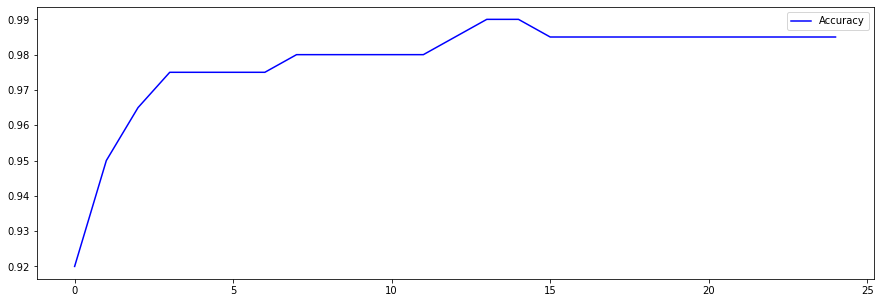

In [136]:
dat = pd.DataFrame({'a': accuracies})
dat['epoch'] = np.arange(epochs)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(dat['epoch'], dat['a'], color='blue', label='Accuracy')
ax.legend();

# Fast Gradient Sign Method (FGSM)

In [137]:
def fgsm_image(image, eps, grad):
    grad_sign = grad.sign()
    fgsm_image = image + eps * grad_sign
    fgsm_image = torch.clamp(fgsm_image, 0, 1)
    return fgsm_image

In [138]:
def adversarial_attack(model, dataset, eps):
    
    model.eval()
    model.train(mode=False)
    loader = DataLoader(dataset, batch_size=1)
   
    x_targets = []   
    adv_images = []   
    
    
    for batch in loader:
        X, y = batch[0], batch[1]
        X.requires_grad = True
       
        y_ = model(X)
        
        predicted = softmax(y_.cpu().detach().numpy())
        
        if y.item() != np.argmax(predicted, axis=1):
            continue
                              
        opt.zero_grad()
                              
        loss_value = loss(y_.float(), y)
        loss_value.retain_grad()
        loss_value.backward(retain_graph=True)
        grad = X.grad
        adv_image = fgsm_image(X, eps, grad)
        
        adv_y = model(adv_image)
                              
        x_targets.append([X, y.item()])
        adv_images.append([adv_image, softmax(adv_y.cpu().detach().numpy())])      

    return x_targets, adv_images


In [140]:
eps = 0
x_targets, adv_images = adversarial_attack(model, dev_small, eps)

for i in range(5):
    bunch = GGBunch()
    plot = plot_digit(x_targets[i][0].detach().numpy(), 'X target digit: '+str(x_targets[i][1]))
    bunch.add_plot(plot, 0, 0)
    plot = plot_digit(adv_images[i][0].detach().numpy(), 'Predicted digit: '+str(np.argmax(adv_images[i][1])))
    bunch.add_plot(plot, 400, 0)
    digit_labels = np.arange(10)
    dat = pd.DataFrame({'labels':digit_labels, 'score':adv_images[i][1][0]})
    plot = ggplot(dat) + geom_histogram(aes('labels', 'score'), stat='identity') + scale_x_discrete()+ ggtitle("Probability distribution")
    bunch.add_plot(plot, 800, 0)
    bunch.show()

In [141]:
eps = 0.1
x_targets, adv_images = adversarial_attack(model, dev_small, eps)

for i in range(5, 10):
    bunch = GGBunch()
    plot = plot_digit(x_targets[i][0].detach().numpy(), 'X target digit: '+str(x_targets[i][1]))
    bunch.add_plot(plot, 0, 0)
    plot = plot_digit(adv_images[i][0].detach().numpy(), 'Predicted digit: '+str(np.argmax(adv_images[i][1])))
    bunch.add_plot(plot, 400, 0)
    digit_labels = np.arange(10)
    dat = pd.DataFrame({'labels':digit_labels, 'score':adv_images[i][1][0]})
    plot = ggplot(dat) + geom_histogram(aes('labels', 'score'), stat='identity') + scale_x_discrete()+ ggtitle("Probability distribution")
    bunch.add_plot(plot, 800, 0)
    bunch.show()

In [142]:
eps = 0.2
x_targets, adv_images = adversarial_attack(model, dev_small, eps)

for i in range(10, 15):
    bunch = GGBunch()
    plot = plot_digit(x_targets[i][0].detach().numpy(), 'X target digit: '+str(x_targets[i][1]))
    bunch.add_plot(plot, 0, 0)
    plot = plot_digit(adv_images[i][0].detach().numpy(), 'Predicted digit: '+str(np.argmax(adv_images[i][1])))
    bunch.add_plot(plot, 400, 0)
    digit_labels = np.arange(10)
    dat = pd.DataFrame({'labels':digit_labels, 'score':adv_images[i][1][0]})
    plot = ggplot(dat) + geom_histogram(aes('labels', 'score'), stat='identity') + scale_x_discrete()+ ggtitle("Probability distribution")
    bunch.add_plot(plot, 800, 0)
    bunch.show()

In [133]:
eps = 0.3
x_targets, adv_images = adversarial_attack(model, dev_small, eps)

for i in range(15, 20):
    bunch = GGBunch()
    plot = plot_digit(x_targets[i][0].detach().numpy(), 'X target digit: '+str(x_targets[i][1]))
    bunch.add_plot(plot, 0, 0)
    plot = plot_digit(adv_images[i][0].detach().numpy(), 'Predicted digit: '+str(np.argmax(adv_images[i][1])))
    bunch.add_plot(plot, 400, 0)
    digit_labels = np.arange(10)
    dat = pd.DataFrame({'labels':digit_labels, 'score':adv_images[i][1][0]})
    plot = ggplot(dat) + geom_histogram(aes('labels', 'score'), stat='identity') + scale_x_discrete()+ ggtitle("Probability distribution")
    bunch.add_plot(plot, 800, 0)
    bunch.show()